# Example : Predictions in ternary diagrams

(c) Charles Le Losq and contributors, 2021-2023,
see embedded licence file

This notebook showcases how predictions can be made from the trained networks in a ternary diagram.

### Library loading and additional function definition

In [1]:
%matplotlib inline

# dataframes and arrays
import pandas as pd 
import numpy as np

# for plotting
import matplotlib.pyplot as plt 
import matplotlib, mpltern#, corner
from mpltern.ternary.datasets import get_spiral
from matplotlib.patches import ArrowStyle, FancyArrowPatch
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

# spearman corr coef
from scipy.stats import spearmanr

# mse
from sklearn.metrics import mean_squared_error

# neuravi internals
import src.imelt as imelt
import src.utils as utils

# other essentials
import torch, time, h5py

# we will work on CPU there
device = torch.device('cpu')

# load dataset and models
ds = imelt.data_loader()
neuralmodel = imelt.load_pretrained_bagged(activation_function=torch.nn.GELU())

### Generate samples

For plotting data in a ternary system, we first randomly generate data in the ternary diagram, using the function constructed below.

Here we focus on glass density, but this can be replicated with other properties

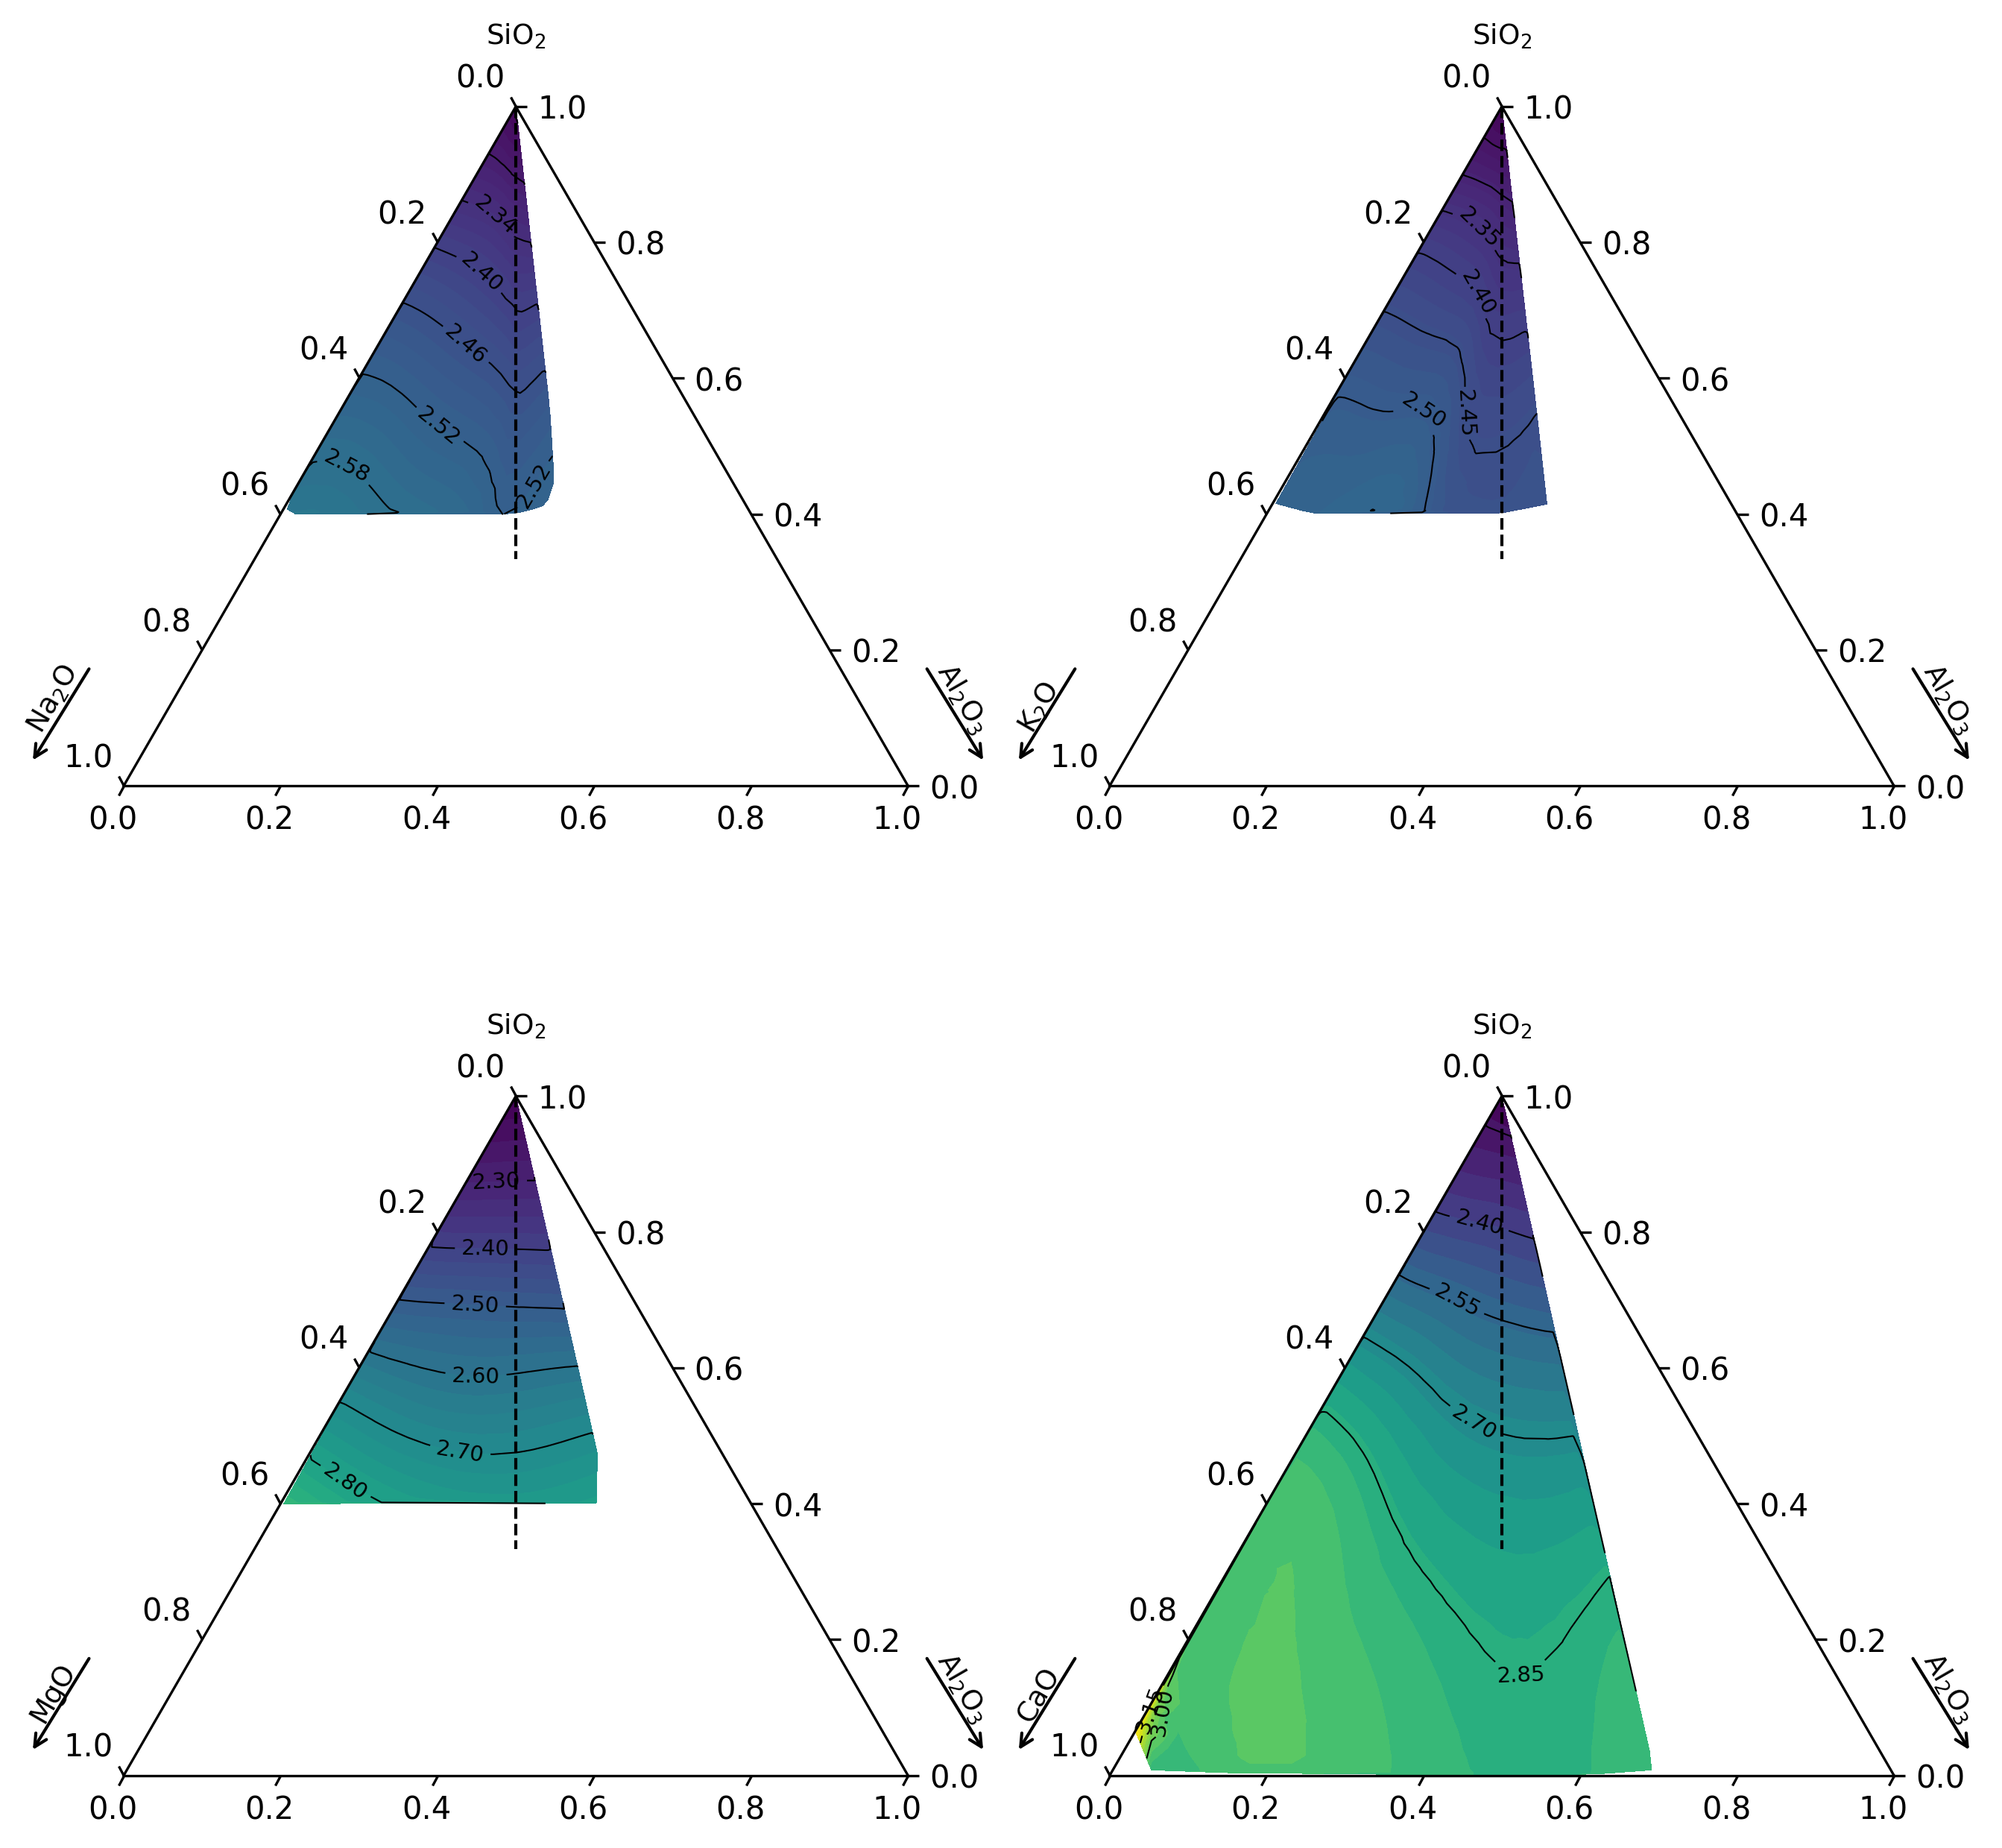

In [9]:
def gen_ternary(nb_samples=1000, cation="na", sio2_low = 0.4, R_MAl_low = 0.4):
    """random composition generation for ternary system"""
    # column position of elements
    cations = {"na":2,"k":3,"mg":4,"ca":5}

    sio2_gen = np.random.random_sample(nb_samples)*(1-sio2_low) + sio2_low
    reminder = 1.0 - sio2_gen
    R_MAl = np.random.random_sample(nb_samples)*(1.0-R_MAl_low) + R_MAl_low # ratio of alkalis to Al
    al2o3_gen = (1.0 - R_MAl)*reminder
    reminder = 1 - sio2_gen - al2o3_gen
    
    # output array
    X_gen_ = np.zeros((len(sio2_gen),6))
    X_gen_[:,0] = sio2_gen
    X_gen_[:,1] = al2o3_gen
    X_gen_[:,cations[cation]] = reminder # we assign the reminder to the choosen cation
    
    X_gen_ = utils.descriptors(pd.DataFrame(X_gen_, columns=["sio2","al2o3","na2o","k2o","mgo","cao"]))
    
    return torch.Tensor(X_gen_.values)
    
X_gen_NAS = gen_ternary(nb_samples=1000, cation="na", sio2_low = 0.4, R_MAl_low = 0.4)
X_gen_KAS = gen_ternary(nb_samples=1000, cation="k", sio2_low = 0.4, R_MAl_low = 0.4)
X_gen_MAS = gen_ternary(nb_samples=1000, cation="mg", sio2_low = 0.4, R_MAl_low = 0.3)
X_gen_CAS = gen_ternary(nb_samples=1000, cation="ca", sio2_low = 0., R_MAl_low = 0.3)

frames = [X_gen_NAS, X_gen_KAS, X_gen_MAS, X_gen_CAS]
X_gen_all = torch.Tensor(np.concatenate(frames, axis=0)).to(device)

# get the coordinated
cart_NAS = imelt.bary2cart(X_gen_NAS[:,(0,1,2)].detach().numpy(), corners=np.array([[0,0],[1,1],[2,0]]))
cart_KAS = imelt.bary2cart(X_gen_KAS[:,(0,1,3)].detach().numpy(), corners=np.array([[0,0],[1,1],[2,0]]))
cart_MAS = imelt.bary2cart(X_gen_MAS[:,(0,1,4)].detach().numpy(), corners=np.array([[0,0],[1,1],[2,0]]))
cart_CAS = imelt.bary2cart(X_gen_CAS[:,(0,1,5)].detach().numpy(), corners=np.array([[0,0],[1,1],[2,0]]))

# predictions
d_NAS = neuralmodel.predict("density_glass",X_gen_NAS).mean(axis=1)
d_KAS = neuralmodel.predict("density_glass",X_gen_KAS).mean(axis=1)
d_MAS = neuralmodel.predict("density_glass",X_gen_MAS).mean(axis=1)
d_CAS = neuralmodel.predict("density_glass",X_gen_CAS).mean(axis=1)
d_all = neuralmodel.predict("density_glass",X_gen_all).mean(axis=1)

# helper function
def plot_ternary(ax, x_1, x_2, x_3, z, colormap, norm):
    tc = ax.tricontourf(x_1, x_2, x_3, z,
                        levels=30, cmap=c_m1, norm=norm1)

    tc = ax.tricontour(x_1, x_2, x_3, z,
                       levels=6, colors="k", norm=norm1, linewidths=0.5)

    ax.clabel(tc, inline=1, fontsize=7, fmt="%1.2f")
    return ax

# declare fig
fig = plt.figure(figsize=(9,9), dpi=300)

# colormap
c_m1 = matplotlib.cm.viridis
# normalisation
norm1 = matplotlib.colors.Normalize(vmin=np.min(d_all), vmax=np.max(d_all))
# scalar mappables for color bars
s_d = matplotlib.cm.ScalarMappable(cmap=c_m1,norm=norm1)

# levels
levels_d = np.arange(2.2,2.8,0.02)

####
#### density TERNARY PLOT
####

ax1 = plt.subplot(2,2,1, projection="ternary")
ax2 = plt.subplot(2,2,2, projection="ternary")
ax3 = plt.subplot(2,2,3, projection="ternary")
ax4 = plt.subplot(2,2,4, projection="ternary")

ax1 = plot_ternary(ax1, X_gen_NAS[:,0],X_gen_NAS[:,2],X_gen_NAS[:,1], d_NAS, c_m1, norm1)
ax2 = plot_ternary(ax2, X_gen_KAS[:,0],X_gen_KAS[:,3],X_gen_KAS[:,1], d_KAS, c_m1, norm1)
ax3 = plot_ternary(ax3, X_gen_MAS[:,0],X_gen_MAS[:,4],X_gen_MAS[:,1], d_MAS, c_m1, norm1)
ax4 = plot_ternary(ax4, X_gen_CAS[:,0],X_gen_CAS[:,5],X_gen_CAS[:,1], d_CAS, c_m1, norm1)

###
### plot tectosilicate join
###
ax1.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax2.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax3.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)
ax4.plot([1.0,0.5],[0.,0.5],[0.,0.5],"--",color="black",linewidth=1)

# label axes
ax1.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax1, 'Na$_2$O', 'Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax1.tick_params(labelrotation='horizontal')

ax2.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax2, 'K$_2$O', 'Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax2.tick_params(labelrotation='horizontal')

ax3.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax3, 'MgO', 'Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax3.tick_params(labelrotation='horizontal')

ax4.set_tlabel('SiO$_2$', fontsize = 9)
imelt.make_arrow(ax4, 'CaO', 'Al$_2$O$_3$', sx1 = -0.12, sx2 = 1.02, fontsize = 9, linewidth=1.)
ax4.tick_params(labelrotation='horizontal')

plt.tight_layout(w_pad=1.)
